# RSNA Bone Age Challenge

In [1]:
# import all libraries
import sys
import random
import pandas as pd
import numpy as np
import cv2

from os import listdir
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

## extra imports to set GPU options
import tensorflow as tf
from keras import backend as K

###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))
###################################

# dimensions of our images
img_width, img_height = 224, 224

# set input shape for differnt backens
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

Using TensorFlow backend.


## Read data

### Read input images from the directory into pandas

In [2]:
# Total num of images to be read
num_imgs = 2000

# Path to images
path_to_images = "../../dataset/bone_age/resized/"

img_files = []

images_dataFrame = pd.DataFrame(columns=['id', 'image'])

# Randomly select files to read
# for i in range(num_imgs):
#     img_files.append(random.choice([x for x in listdir(path_to_images)]))

img_files =  listdir(path_to_images)

# Read images
count = 0
for img_file in img_files[:num_imgs]:
    name = img_file.split('.')[0]
    try:
        img = cv2.imread(path_to_images + img_file)#, cv2.COLOR_BGR2GRAY)
        img = np.array(img, dtype='float32')
        images_dataFrame.loc[count] = [name, img]
        count += 1
    except(IOError, OSError):
        print('error')
        pass
images_dataFrame.head()

,id,image
0,1616,"[[[6.0, 6.0, 6.0], [6.0, 6.0, 6.0], [6.0, 6.0,..."
1,9119,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,12438,"[[[13.0, 13.0, 13.0], [10.0, 10.0, 10.0], [10...."
3,9834,"[[[13.0, 13.0, 13.0], [13.0, 13.0, 13.0], [14...."
4,13915,"[[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]..."


### Read image annotations form csv file into pandas

In [3]:
path_to_csv = "../../dataset/bone_age/ntrain.csv"

annotations_dataFrame = pd.read_csv(path_to_csv)
loaded_imgsDataFrame = pd.DataFrame()

for img in img_files:
    img_id = int(img.split('.')[0])
    loaded_imgsDataFrame = loaded_imgsDataFrame.append(annotations_dataFrame.loc[annotations_dataFrame['id'] == img_id], ignore_index=True)
loaded_imgsDataFrame.head()

,id,boneage,male
0,1616,48,True
1,9119,156,False
2,12438,106,False
3,9834,100,False
4,13915,120,False


### Combine image and annotation dataframes and split to training and testing sets

In [4]:
input_dataFrame = pd.merge(loaded_imgsDataFrame, images_dataFrame, right_index=True, left_index=True)
input_dataFrame.head()

,id_x,boneage,male,id_y,image
0,1616,48,True,1616,"[[[6.0, 6.0, 6.0], [6.0, 6.0, 6.0], [6.0, 6.0,..."
1,9119,156,False,9119,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,12438,106,False,12438,"[[[13.0, 13.0, 13.0], [10.0, 10.0, 10.0], [10...."
3,9834,100,False,9834,"[[[13.0, 13.0, 13.0], [13.0, 13.0, 13.0], [14...."
4,13915,120,False,13915,"[[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]..."


In [5]:
input_dataFrame.drop('id_x', axis=1, inplace=True) # drop id_x column
input_dataFrame.drop('id_y', axis=1, inplace=True) # drop id_y column
input_dataFrame.head()

,boneage,male,image
0,48,True,"[[[6.0, 6.0, 6.0], [6.0, 6.0, 6.0], [6.0, 6.0,..."
1,156,False,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,106,False,"[[[13.0, 13.0, 13.0], [10.0, 10.0, 10.0], [10...."
3,100,False,"[[[13.0, 13.0, 13.0], [13.0, 13.0, 13.0], [14...."
4,120,False,"[[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]..."


## Prepare Data

### Conver  gender to string

In [6]:
# Rename Male to Gender
# Female i.e. False is repalces by 1
# Male i.e. True is replaced by 0
input_dataFrame.rename(columns={'male':'gender'}, inplace=True)
input_dataFrame['gender'].replace(True, '1', inplace=True)
input_dataFrame['gender'].replace(False, '0', inplace=True)
input_dataFrame['gender'] = input_dataFrame['gender'].apply(pd.to_numeric)
input_dataFrame.head()

,boneage,gender,image
0,48,1,"[[[6.0, 6.0, 6.0], [6.0, 6.0, 6.0], [6.0, 6.0,..."
1,156,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,..."
2,106,0,"[[[13.0, 13.0, 13.0], [10.0, 10.0, 10.0], [10...."
3,100,0,"[[[13.0, 13.0, 13.0], [13.0, 13.0, 13.0], [14...."
4,120,0,"[[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]..."


### Data augmentation

In [7]:
# input_data = input_dataFrame.values
# image_data = input_dataFrame["image"].values
gender_data = input_dataFrame["gender"].values
age_data = input_dataFrame["boneage"].values

ls = []
for i, x in input_dataFrame.iterrows():
    ls.append(input_dataFrame.loc[i, 'image'])
    
image_data = np.array(ls, dtype='float32')

batch_size = 5

train_data_gen = ImageDataGenerator(
    rescale = 1./255
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
)

val_data_gen = ImageDataGenerator(
    rescale = 1./255
#     width_shift_range=0.25,
#     height_shift_range=0.25,
#     horizontal_flip = True
)

def gen_train_two_inputs(x, y, z):
    X1 = train_data_gen.flow(x, y, batch_size=batch_size, seed=2)
    X2 = train_data_gen.flow(x, z, batch_size=batch_size, seed=2)
    while True:
        X1i = X1.next()
        X2i = X2.next()
        yield [X1i[0], X1i[1]], X2i[1]
        
def gen_val_two_inputs(x, y, z):
    X1 = val_data_gen.flow(x, y, batch_size=batch_size, seed=2)
    X2 = val_data_gen.flow(x, z, batch_size=batch_size, seed=2)
    while True:
        X1i = X1.next()
        X2i = X2.next()
        yield [X1i[0], X1i[1]], X2i[1]

### Split training and validation

In [8]:
training_size = int(.85 * num_imgs)
train_gen_flow = gen_train_two_inputs(image_data[training_size:], gender_data[training_size:], age_data[training_size:])
val_gen_flow = gen_val_two_inputs(image_data[:training_size], gender_data[:training_size], age_data[:training_size])

## The Model

### Model

In [9]:
### Pretrained model
from keras.applications.vgg16 import VGG16
from keras.models import Model
import keras
from keras.models import Model
from keras.models import Input

base_model = VGG16(input_shape=input_shape, weights='imagenet', include_top=False)
for layer in base_model.layers:
    layer.trainable = False

pixel_branch = base_model.output
pixel_branch = Flatten()(pixel_branch)

new_model = Model(inputs=base_model.input, outputs=pixel_branch)

text_branch = Sequential()
text_branch.add(Dense(32, input_shape=(1,), activation='relu'))

# merged = Merge([new_model, text_branch], mode='concat')
merged = keras.layers.concatenate([new_model.output, text_branch.output])

age = Dense(1000, activation='relu')(merged)
age = Dense(1000, activation='relu')(age)
age = Dense(1)(age)

# show model
# model.summary()
model = Model(inputs=[base_model.input, text_branch.input], outputs=age)

In [10]:
# compile mode
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) 
model.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['accuracy'])

In [11]:
# Call backs
save_best = ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001) 

In [12]:
# fit data
model.fit_generator(
    train_gen_flow,
    steps_per_epoch=340,
    epochs=50,
    validation_data=val_gen_flow,
    validation_steps=60,
    callbacks=[save_best, reduceLROnPlat]
)

Epoch 1/50
340/340 [==============================] - 98s 289ms/step - loss: 29.9679 - acc: 0.0112 - val_loss: 23.3095 - val_acc: 0.0133
Epoch 2/50
340/340 [==============================] - 95s 281ms/step - loss: 17.9118 - acc: 0.0165 - val_loss: 25.7636 - val_acc: 0.0033
Epoch 3/50
340/340 [==============================] - 96s 283ms/step - loss: 13.4691 - acc: 0.0212 - val_loss: 23.8137 - val_acc: 0.0067
Epoch 4/50
340/340 [==============================] - 97s 284ms/step - loss: 11.8141 - acc: 0.0371 - val_loss: 21.7197 - val_acc: 0.0333
Epoch 5/50
340/340 [==============================] - 96s 282ms/step - loss: 9.6812 - acc: 0.0353 - val_loss: 22.6171 - val_acc: 0.0100
Epoch 6/50
340/340 [==============================] - 96s 281ms/step - loss: 7.1805 - acc: 0.0594 - val_loss: 20.1900 - val_acc: 0.0100
Epoch 7/50
340/340 [==============================] - 95s 281ms/step - loss: 7.3422 - acc: 0.0512 - val_loss: 22.5483 - val_acc: 0.0133
Epoch 8/50
340/340 [========================

In [13]:
# model.save_weights('bone_age_weights_20_ep.h5')

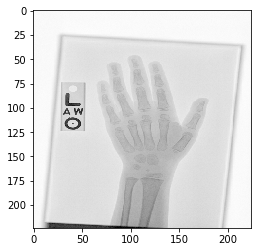

In [14]:
import matplotlib.pyplot as plt

plt.imshow(image_data[0])
plt.show()

In [15]:
np.array([0]).shape

(1,)

In [16]:
output = model.predict([image_data[:5], gender_data[:5]])

In [17]:
output

array([[  303.13580322],
       [  856.51965332],
       [ 1291.22424316],
       [ 1216.98962402],
       [ 2068.30395508]], dtype=float32)